# initialize the NUImages dataset

In [1]:
from nuimages import NuImages

nuim = NuImages(dataroot='nuimages', version='v1.0-train', verbose=True, lazy=True)

Loading nuImages tables for version v1.0-train...
Done loading in 0.000 seconds (lazy=True).


## Get total images

In [2]:
samples = nuim.sample
TOTAL_IMAGES = len(nuim.sample)
print("Total images:", TOTAL_IMAGES)

Loaded 67279 sample(s) in 0.262s,
Total images: 67279


## Try rendering roads

Loaded 872181 sample_data(s) in 7.591s,
Loaded 73755 surface_ann(s) in 7.394s,
Loaded 25 category(s) in 0.014s,


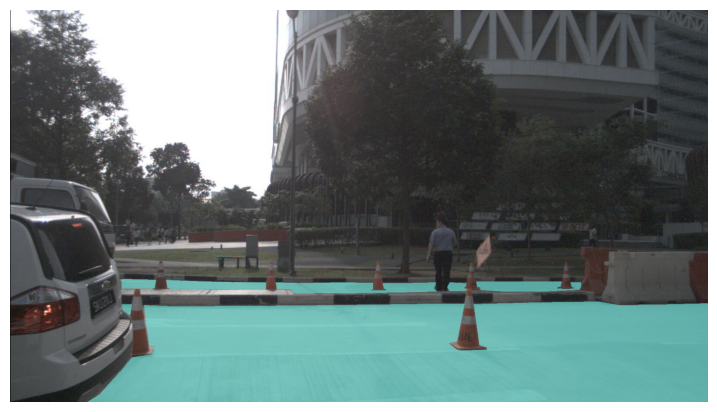

In [3]:
sample_idx = 567

def render(index, annotated=True):
    sample = nuim.get('sample', samples[index]['token'])
    key_camera_token = sample['key_camera_token']
    nuim.render_image(key_camera_token, annotation_type='surfaces' if annotated else 'none')

render(sample_idx, annotated=True)

## Functions for getting road segmentations

Loaded 557715 object_ann(s) in 11.771s,


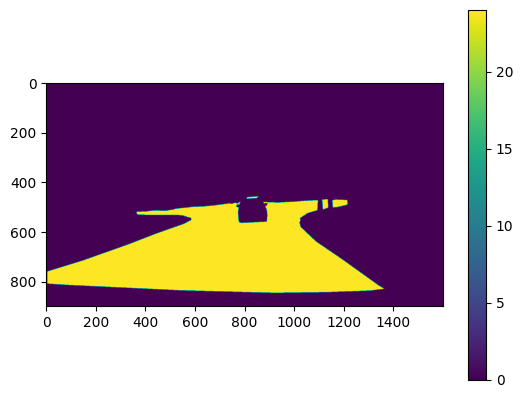

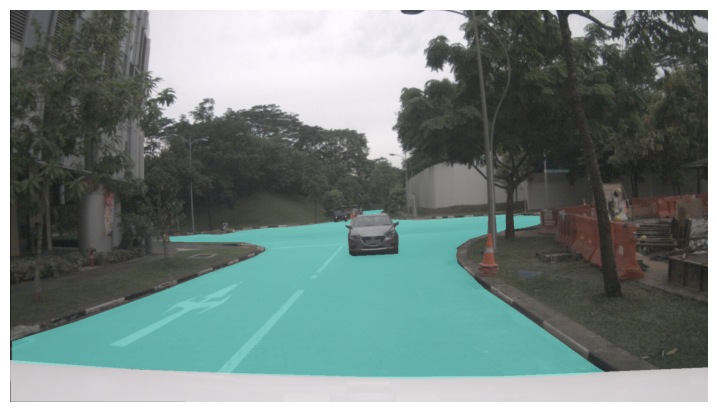

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from functools import lru_cache
import os
from numba import njit

@njit
def remove_everything_else(semantic_mask):
    # Use a JIT-compiled loop for maximum performance
    for i in range(semantic_mask.shape[0]):
        for j in range(semantic_mask.shape[1]):
            if semantic_mask[i, j] != 24:
                semantic_mask[i, j] = 0
    return semantic_mask

@lru_cache(maxsize=256) 
def get_sample(token):
    return nuim.get('sample', token)

@lru_cache(maxsize=256)
def get_segmentation_from_token(token):
    return nuim.get_segmentation(token)

def get_segmentation(index):
    key_camera_token = get_sample(samples[index]['token'])['key_camera_token']
    semantic_mask, _ = get_segmentation_from_token(key_camera_token)
    semantic_mask = remove_everything_else(semantic_mask)
    return key_camera_token, semantic_mask

def show_image_and_annotation(index, semantic_mask):
    plt.imshow(semantic_mask)
    plt.colorbar()
    plt.show()
    render(index, annotated=True)

sample_idx = 88
token, semantic_mask = get_segmentation(sample_idx)
show_image_and_annotation(sample_idx, semantic_mask)

# Functions for saving and loading arrays from files.
## (Just in case)

In [5]:
def save_annotation(filename:int, arr:np.array):
    np.save(f'ann/{filename}.npy', arr)

def load_annotation(filename:int):
    return np.load(f'ann/{filename}.npy')

## Create dataset
##### I dont want to use the entire 67,000 images, so when initializing the dataset object, you can enter a size to select the first [size] images from the dataset

In [7]:
from torch.utils.data import Dataset
from torchvision import transforms
from torch import rand
import os
from PIL import Image

image_to_tensor = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize the image to 512x512
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

resize_mask_to_tensor = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to 512x512
    transforms.ToTensor()           # Convert to PyTorch Tensor
])

def show_tensor(tensor):
    # Convert tensor to NumPy array
    # Transpose from (C, H, W) to (H, W, C) for displaying
    image_np = tensor.permute(1, 2, 0).numpy()
    # Display the image
    plt.imshow(image_np)
    plt.show()

class NuScenesDataset(Dataset):
    def __init__(self, size):
        self.samples = samples[:size]
        pass

    def __len__(self):
        return len(self.samples)

    def get_raw_data(self, idx):
        # get the mask
        chosen_sample = nuim.get('sample', self.samples[idx]['token']) #get sample
        token_from_index = chosen_sample['key_camera_token'] # get token of mask from sample
        mask, _ = get_segmentation_from_token(token_from_index) # get segmentation from token
        mask[mask != 24] = 0 # 24 is the id for the road segmentations
        # get the image
        sample_data = nuim.get('sample_data', token_from_index) # get image file name
        im_path = os.path.join("nuimages", sample_data['filename']) # get full image path
        image = Image.open(im_path) 
        return image, mask

    def __getitem__(self, idx):
        image, mask = self.get_raw_data(idx)
        image_mask = Image.fromarray(mask) # convert raw data to tensors (resize to 512x512, convert to tensor)
        return image_to_tensor(image), (resize_mask_to_tensor(image_mask) != 0).float() # for the mask, change all instances of 24 to 1

# Create Dataset and DataLoader
DATASET_SIZE = 5000
dataset = NuScenesDataset(DATASET_SIZE)
full_dataset = NuScenesDataset(67279)

## Create dataloaders

In [8]:
from torch import manual_seed
from torch.utils.data import DataLoader, random_split

# Assuming `dataset` is your PyTorch Dataset instance
dataset_size = len(dataset)

# Set a random seed for reproducibility (optional)
manual_seed(42)

# Define the proportions of the dataset
train_ratio = 0.7  # 70% for training
val_ratio = 0.15    # 15% for validation
test_ratio = 0.15   # 15% for testing

# Calculate the sizes for each subset
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size  # Ensure all data is used

# Split the dataset into training, validation, and testing subsets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for training, validation, and testing
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example output to verify the sizes
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(eval_loader.dataset)}")
print(f"Testing dataset size: {len(test_loader.dataset)}")

Training dataset size: 3500
Validation dataset size: 750
Testing dataset size: 750


## Try out the dataset
#### This uses the dataset to load a random image and mask

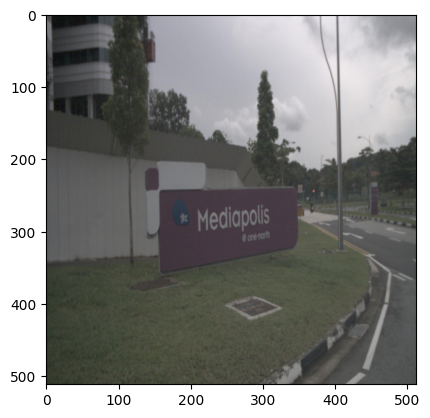

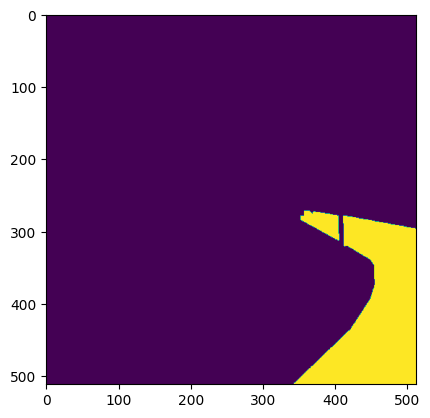

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.]]])


In [10]:
import random

random_index = random.randint(0, DATASET_SIZE)
image, mask = dataset[random_index]
image_raw, mask_raw = dataset.get_raw_data(random_index)

show_tensor(image)
show_tensor(mask)
print(mask)

# Define model and custom head for training

In [11]:
import torch
from torchvision import models
from torch import nn

class VGGBackboneUNet(nn.Module):
    def __init__(self):
        super(VGGBackboneUNet, self).__init__()
        
        # Load pretrained VGG16 and extract the convolutional layers (encoder)
        vgg16 = models.vgg16_bn(pretrained=True)
        self.encoder = vgg16.features
        
        # Define decoder layers (upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # Upconv 1 (from 32x32 -> 64x64)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # Upconv 2 (from 64x64 -> 128x128)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # Upconv 3 (from 128x128 -> 256x256)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1),                        # Final output (binary map)
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=True)  # Resize to 512x512
        )
    
    def forward(self, x):
        # Encode using VGG16 (backbone)
        x = self.encoder(x)
        
        # Decode to produce segmentation map
        x = self.decoder(x)
        
        # No activation (e.g., sigmoid) here since we will use BCEWithLogitsLoss
        return x

model = VGGBackboneUNet()
model.eval()  # Set the model to evaluation mode

c:\Compilers\Python\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Compilers\Python\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGGBackboneUNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv

## Define checkpoint saving/loading functions

In [12]:
def save_checkpoint(model, optimizer, epoch, file_path):
    """Saves the model and optimizer state to a checkpoint file."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved to {file_path}")

def load_checkpoint(model, optimizer, file_path):
    """Loads the model and optimizer state from a checkpoint file."""
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Checkpoint loaded from {file_path}, starting from epoch {epoch}")
    return epoch

In [13]:
import torch.optim as optim
import torch.nn as nn
torch.cuda.empty_cache()

#! Confirm number of batches
print("Training with", len(train_loader), "batches")
print("Evaluating with", len(eval_loader), "batches")

#! Initialize stuff
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Performing on device:", device)

#! Load model and optimizer from file (if any)
""" load_checkpoint(model, optimizer, "VGG_700_2.ckpt") """

#TODO 

model.to(device) # move to device
model.train()
num_epochs = 1

for epoch in range(num_epochs):
    epoch_loss = 0

    for index, (image, mask) in enumerate(train_loader):
        print(f"Now training batch {index} epoch {epoch}.")
        image, mask = image.to(device), mask.to(device)

        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, mask)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        print("Loss:", loss.item())
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader)}")

    model.eval()  # Set the model to evaluation mode
    eval_loss = 0
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():  # No gradient computation for evaluation
        for index, (eval_image, eval_mask) in enumerate(eval_loader):
            eval_image, eval_mask = eval_image.to(device), eval_mask.to(device)
            print(f"Now evaluating batch {index} epoch {epoch}.")
            
            eval_output = model(eval_image)
            eval_loss += criterion(eval_output, eval_mask).item()

            # Optionally calculate other metrics (e.g., accuracy, IoU) here
            preds = torch.sigmoid(eval_output) > 0.5
            total_correct += (preds == eval_mask.byte()).sum().item()  # Convert mask to byte for comparison
            total_pixels += eval_mask.numel()  # Total number of pixels in the mask
            
    classification_error = 1 - (total_correct / total_pixels)  # Error rate
    print(f"Epoch [{epoch + 1}/{num_epochs}], Evaluation Loss: {eval_loss / len(eval_loader)}")
    print(f"Classification Error: {classification_error:.4f}")  # Print the classification error

save_checkpoint(model, optimizer, epoch, f"VGG_comma_{len(train_loader.dataset)}_{num_epochs}.ckpt")

Training with 875 batches
Evaluating with 188 batches
Performing on device: cuda


C:\Users\dimas\AppData\Local\Temp\ipykernel_15048\860490446.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Checkpoint loaded from VGG_700_2.ckpt, starting from epoch 2
Now training batch 0 epoch 0.


KeyboardInterrupt: 

## Test forward pass on just one random sample for testing

### Heaviside function used to make sure all outputs are 0 or 1 based on sign

C:\Users\dimas\AppData\Local\Temp\ipykernel_15048\860490446.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Checkpoint loaded from VGG_nuscenes_3500_2.ckpt, starting from epoch 0


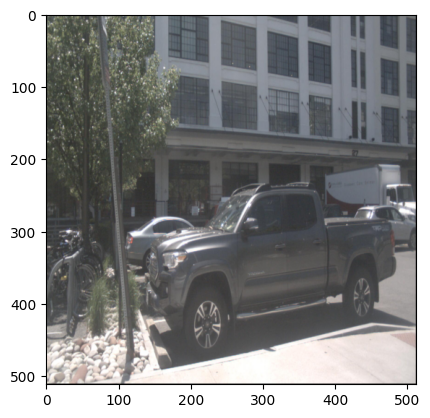

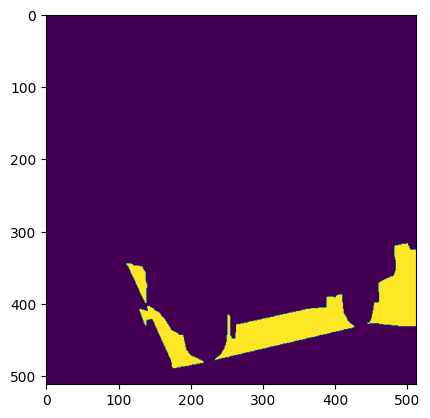

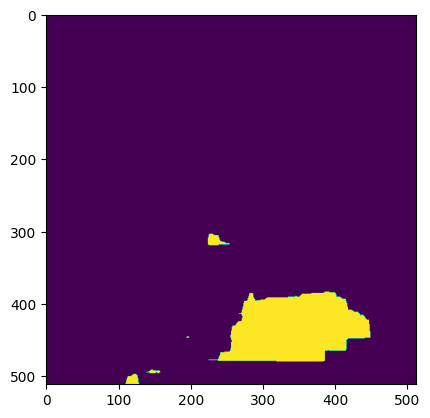

In [51]:
load_checkpoint(model, optimizer, "VGG_nuscenes_3500_2.ckpt")

model.eval()
image, mask = full_dataset[random.randint(3500, 67272)]

def heaviside(x):
    return torch.where(x < 0, torch.tensor(0.0), 
           torch.where(x > 0, torch.tensor(1.0), torch.tensor(0.5)))

show_tensor(image)
image = image.unsqueeze(0)
image = image.to(device)
model = model.to(device)
output = model(image)
heav = heaviside(output.squeeze(0).detach().cpu())
show_tensor(mask)
show_tensor(heav)

## Save model params and optimizer
### My convention: MODELNAME_datasetname_[training dataset size]_[epoch_number].ckpt

In [50]:
save_checkpoint(model, optimizer, 2, "VGG_700_2.ckpt")

Checkpoint saved to VGG_700_2.ckpt
